# Ensemble learning: QRT Challenge

## Load libraries

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from prophet.diagnostics import cross_validation
from prophet import Prophet
import numpy as np
from scipy.stats import spearmanr
from sklearn.metrics import make_scorer
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance

## Load file

In [38]:
#Google Drive access
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
X_train = pd.read_csv("/content/drive/Shareddrives/Ensemble Learning/data/x_train.csv")
X_test = pd.read_csv("/content/drive/Shareddrives/Ensemble Learning/data/x_test.csv")
y_train = pd.read_csv("/content/drive/Shareddrives/Ensemble Learning/data/y_train.csv")
X_train['DATE'] = pd.to_datetime(X_train['DATE'])
X_test['DATE'] = pd.to_datetime(X_test['DATE'])
X_train['Year'] = X_train['DATE'].dt.year
X_train['Month'] = X_train['DATE'].dt.month
X_train['Day'] = X_train['DATE'].dt.day

X_test['Year'] = X_test['DATE'].dt.year
X_test['Month'] = X_test['DATE'].dt.month
X_test['Day'] = X_test['DATE'].dt.day
X_train.drop(columns=['DATE'], inplace=True)
X_test.drop(columns=['DATE'], inplace=True)

## Define Spearman correlation

In [40]:
def spearman_scorer(y_true, y_pred):
    #Calculate Spearman's correlation
    correlation, _ = spearmanr(y_true, y_pred)
    return correlation

#Create a scorer that can be used in GridSearchCV
spearman_scoring = make_scorer(spearman_scorer)

##Split train/test

In [41]:
#Split the train set to train the model
X_train_split, X_val_split, Y_train_split, Y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Adaboost

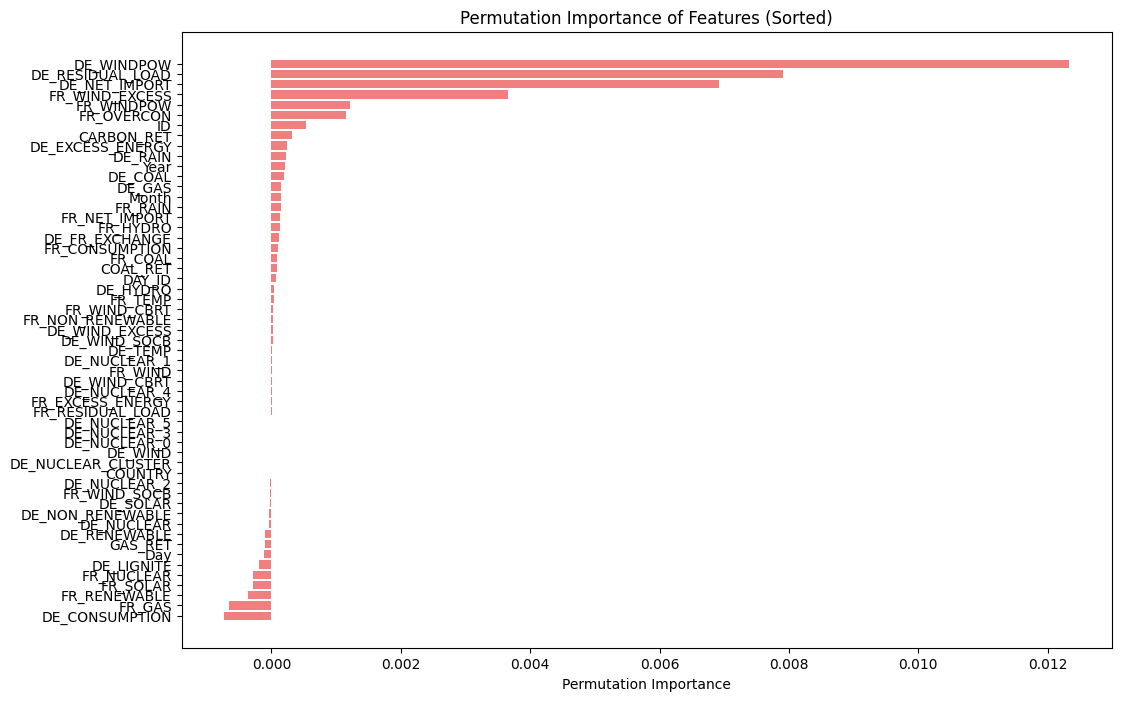

Mean Squared Error on the validation set: 1.1724004932845071
Mean Absolute Error on the validation set: 0.5958562707066192
Spearman Correlation on the validation set: 0.1599001032663045
Grid Search best params : {'learning_rate': 0.01, 'n_estimators': 200}


In [45]:
base_model = DecisionTreeRegressor(max_depth=3)
adaboost_model = AdaBoostRegressor(base_model)

#Hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
}

#GridSearchCV
grid_search_adaboost = GridSearchCV(adaboost_model, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search_adaboost.fit(X_train_split, Y_train_split.drop(columns=['ID']).values.ravel())

#Best params
best_params_adaboost = grid_search_adaboost.best_params_

#New Adaboost model with the best params
best_adaboost_model = AdaBoostRegressor(base_model, **best_params_adaboost)

#Train the model with the best parameters
best_adaboost_model.fit(X_train_split, Y_train_split.drop(columns=['ID']).values.ravel())
result = permutation_importance(
    best_adaboost_model, X_val_split, Y_val_split.drop(columns=['ID']).values.ravel(), n_repeats=30, random_state=42
)

#Plot feature importances
feature_importance = result.importances_mean
sorted_idx = np.argsort(feature_importance)

plt.figure(figsize=(12, 8))
plt.barh(X_val_split.columns[sorted_idx], feature_importance[sorted_idx], color='lightcoral')
plt.xlabel('Permutation Importance')
plt.title('Permutation Importance of Features (Sorted)')
plt.show()

#Predictions on the validation set
best_adaboost_predictions = best_adaboost_model.predict(X_val_split)

#Evaluate the model performance on the validation set
best_adaboost_mse = mean_squared_error(Y_val_split.drop(columns=['ID']).values.ravel(), best_adaboost_predictions)
print(f'Mean Squared Error on the validation set: {best_adaboost_mse}')

mae = mean_absolute_error(Y_val_split.drop(columns=['ID']).values.ravel(), best_adaboost_predictions)
print(f'Mean Absolute Error on the validation set: {mae}')

spearman_corr = spearmanr(Y_val_split.drop(columns=['ID']).values.ravel(), best_adaboost_predictions).correlation
print(f'Spearman Correlation on the validation set: {spearman_corr}')

# Print Grid Search best params
print(f'Grid Search best params : {grid_search_adaboost.best_params_}')

## Submission

In [43]:
Y_test_submission_fe = X_test[['ID']].copy()
Y_test_submission_fe['TARGET'] = best_adaboost_model.predict(X_test)
Y_test_submission_fe.to_csv('benchmark_qrt_fe.csv', index=False)